In [1]:
'''Training the model & testing on Test set in this Script'''

import numpy as np
import time, sys, os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import argparse
import matplotlib.pyplot as plt

import dataload, model

In [2]:
def print_function(i, num_batches, acc_temp):
    j = int(i/25)
    sys.stdout.write('\r{0}'.format('Batches: ' + str(i+1) + '/' + str(num_batches) +\
                                    ' [' + '='*j + '>' + (int((num_batches)/25)-j) * ' ' + '] ' + \
                                    str(round((i+1)*100/num_batches)) + '%; Accuracy: ' + \
                                    str(acc_temp)))
    sys.stdout.flush()
    pass

def data_augmentation(loader):
    t_loader = []
    
    for i, (batch_x, batch_y) in enumerate(loader):
        sess = tf.Session()
        num_sample = len(batch_x)
        aug_size = int(0.05*num_sample)
        idx = np.random.choice(np.arange(num_sample), replace=False, size=aug_size)
        b_x = batch_x[idx]
        b_y = batch_y[idx]

        rot_img = tf.image.flip_left_right(b_x.reshape((aug_size, 28, 28)))
        b_x = sess.run(rot_img).reshape((aug_size, 28 * 28))
        batch_x = np.vstack((batch_x, b_x))
        batch_y = np.vstack((batch_y, b_y))

        idx = np.random.choice(np.arange(num_sample), replace=False, size=aug_size)
        b_x = batch_x[idx]
        b_y = batch_y[idx]
        rot_img = tf.image.random_flip_up_down(b_x.reshape((aug_size, 28, 28)))
        b_x = sess.run(rot_img).reshape((aug_size, 28 * 28))
        batch_x = np.vstack((batch_x, b_x))
        batch_y = np.vstack((batch_y, b_y))
        
        idx = np.random.choice(np.arange(num_sample), replace=False, size=aug_size)
        b_x = batch_x[idx]
        b_y = batch_y[idx]
        rot_img = tf.image.random_flip_up_down(b_x.reshape((aug_size, 28, 28)))
        rot_img = tf.image.random_flip_left_right(rot_img, seed = None)
        b_x = sess.run(rot_img).reshape((aug_size, 28 * 28))
        batch_x = np.vstack((batch_x, b_x))
        batch_y = np.vstack((batch_y, b_y))

        t_loader.append((batch_x, batch_y))
    sess.close()
    return t_loader

In [3]:
def train(args = None):
    epochs = 40
    validation = True
    train_stats, valid_stats = [], []
    train_stats_l, valid_stats_l = [], []
    patience = 10
    
    if opt == 1:
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(model.loss)
    else:
        optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(model.loss)
    
    saver = tf.train.Saver(tf.trainable_variables())

    config = tf.ConfigProto(intra_op_parallelism_threads=6, inter_op_parallelism_threads=6,
                            device_count = {'CPU': 6})
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Training Started!!')
        
        num_batches = len(train_loader)
        best_valid_acc = 0
        best_valid_loss = 1e+10
        early_limit = 0

        for e in range(epochs):
            if early_limit > patience:
                print('Early stop! No improvement in Validation Loss since %s Epochs!'%(patience))
                print('-'*65)
                break
            
            print('Epoch: ', e+1)
            start = time.time()
            valid_score = 0
            train_accuracies, train_loss = [], []

            for i, (batch_x, batch_y) in enumerate(train_loader):
                num_sample = len(batch_x)
                
                acc_temp = round(np.mean(train_accuracies), 4) if len(train_accuracies) != 0 else 'NA'
                print_function(i, num_batches, acc_temp)

                _, acc, loss = sess.run([optimizer, model.accuracy, model.loss],
                                        feed_dict={x: batch_x, y: batch_y})
                train_accuracies.append(acc)
                train_loss.append(loss)
            acc = np.mean(train_accuracies)
            loss_train = np.mean(train_loss)
            t = time.time() - start
            print('\nTime: %s sec; Traning Accuracy %.3f; Training Loss: %.3f'%(round(t), acc, loss_train))

            #Validation
            if validation:
                valid_accuracies, valid_loss = [], []
                for i, (batch_x, batch_y) in enumerate(valid_loader):
                    acc, loss = sess.run([model.accuracy, model.loss], feed_dict = {x: batch_x, y: batch_y})
                    valid_accuracies.append(acc)
                    valid_loss.append(loss)
                valid_acc, loss_valid = np.mean(valid_accuracies), np.mean(valid_loss)
                print('Validation Accuracy %.3f; Validation Loss: %.3f'%(valid_acc, loss_valid))
                if valid_acc > best_valid_acc:
                    acc = int(round(valid_acc*100)); best_valid_acc = valid_acc
                    print('Best Validation Accuracy achieved at Epoch: %s is %.3f'%(e+1, best_valid_acc))
                    ckpt_file = os.path.join(model_dir, 'best_model_da.ckpt')
                    saver.save(sess, ckpt_file)
                if loss_valid < best_valid_loss:
                    best_valid_loss = loss_valid
                    early_limit = 0
            print('-'*65)
            early_limit = early_limit + 1
            train_stats.append(train_accuracies); train_stats_l.append(train_loss)
            valid_stats.append(valid_accuracies); valid_stats_l.append(valid_loss)
        print('Training Completed!!'); print('-'*65)
    return train_stats, train_stats_l, valid_stats, valid_stats_l
                                             
def test(args = None):
    config = tf.ConfigProto(intra_op_parallelism_threads=6, inter_op_parallelism_threads=6,
                            device_count = {'CPU': 6})
    saver = tf.train.Saver(tf.trainable_variables())

    with tf.Session(config = config) as sess:
        sess.run(tf.local_variables_initializer())
        print('Testing the model on 10000 Images!')
        ckpt_file = os.path.join(model_dir, best_val_model)
        saver.restore(sess, ckpt_file)

        test_predicted = []
        for i, (batch_x, batch_y) in enumerate(test_loader):
            correct = sess.run([model.correct_predicted], feed_dict = {x: batch_x, y: batch_y})
            test_predicted.append(np.sum(correct))
        test_acc = np.sum(test_predicted)/num_samples_test
        print('Testing Accuracy %.3f'%(test_acc))
    pass

Training Started!!
Epoch:  1
Batches: 422/422 [================>] 100%; Accuracy: 0.8281
Time: 340 sec; Traning Accuracy 0.828; Training Loss: 0.507
Validation Accuracy 0.875; Validation Loss: 0.350
Best Validation Accuracy achieved at Epoch: 1 is 0.875
-----------------------------------------------------------------
Epoch:  2
Batches: 422/422 [================>] 100%; Accuracy: 0.8886
Time: 339 sec; Traning Accuracy 0.889; Training Loss: 0.303
Validation Accuracy 0.878; Validation Loss: 0.331
Best Validation Accuracy achieved at Epoch: 2 is 0.878
-----------------------------------------------------------------
Epoch:  3
Batches: 422/422 [================>] 100%; Accuracy: 0.9089
Time: 367 sec; Traning Accuracy 0.909; Training Loss: 0.246
Validation Accuracy 0.894; Validation Loss: 0.299
Best Validation Accuracy achieved at Epoch: 3 is 0.894
-----------------------------------------------------------------
Epoch:  4
Batches: 422/422 [================>] 100%; Accuracy: 0.924
Time: 333

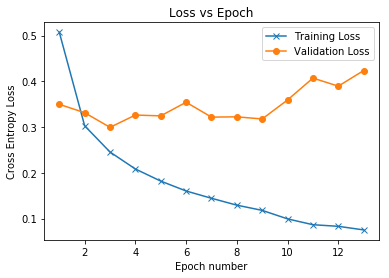

In [4]:
batch_size = 128
model_dir = './model/'
testing = 0
lr = 1e-3
opt = 1
mode = 'train'
data_aug = 0

Loader = dataload.DataLoader()
x, y = Loader.load_data()

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

num_classes = len(np.unique(y_train))

x = tf.placeholder(dtype=tf.float32, shape = (None, x_train.shape[1]))
y = tf.placeholder(dtype=tf.float32, shape = (None, num_classes))

model = model.CNN(x, y)

if testing:
    x_test, y_test = Loader.load_data(mode = 'test')
    test_loader = Loader.create_batches(x_test, y_test, batch_size = batch_size)
    num_samples_test = x_test.shape[0]
    
    test()
else:
    if data_aug == 1:
        print('Data Augmentation started!!')
        start = time.time()
        loader = Loader.create_batches(x_train, y_train, batch_size = batch_size)
        train_loader = data_augmentation(loader)
        print('Data Augmentation complete! Time Elapsed: %s sec'%(int(time.time()-start)))
    else:
        train_loader = Loader.create_batches(x_train, y_train, batch_size = batch_size)
        
    valid_loader = Loader.create_batches(x_valid, y_valid, batch_size = batch_size)

    train_stats, train_stats_l, valid_stats, valid_stats_l = train()
    epoch_loss_t = np.mean(train_stats_l, axis = 1)
    epoch_loss_v = np.mean(valid_stats_l, axis = 1)
    
    num_epochs = np.arange(1, len(epoch_loss_t)+1)

    plt.plot(num_epochs, epoch_loss_t, marker = 'x')
    plt.plot(num_epochs, epoch_loss_v, marker = 'o')
    plt.xlabel('Epoch number')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss vs Epoch')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

In [7]:
x_test, y_test = Loader.load_data(mode = 'test')
test_loader = Loader.create_batches(x_test, y_test, batch_size = batch_size)
num_samples_test = x_test.shape[0]

best_val_model = 'best_model_da.ckpt'

test()

Testing the model on 10000 Images!
INFO:tensorflow:Restoring parameters from ./model/best_model_da.ckpt
Testing Accuracy 0.903


In [8]:
opt = 2
train_stats_r, train_stats_l_r, valid_stats_r, valid_stats_l_r = train()

epoch_loss_t_r = np.mean(train_stats_l_r, axis = 1)
epoch_loss_v_r = np.mean(valid_stats_l_r, axis = 1)


Training Started!!
Epoch:  1
Batches: 422/422 [================>] 100%; Accuracy: 0.7355
Time: 325 sec; Traning Accuracy 0.736; Training Loss: 0.757
Validation Accuracy 0.874; Validation Loss: 0.357
Best Validation Accuracy achieved at Epoch: 1 is 0.874
-----------------------------------------------------------------
Epoch:  2
Batches: 422/422 [================>] 100%; Accuracy: 0.8793
Time: 331 sec; Traning Accuracy 0.879; Training Loss: 0.325
Validation Accuracy 0.890; Validation Loss: 0.318
Best Validation Accuracy achieved at Epoch: 2 is 0.890
-----------------------------------------------------------------
Epoch:  3
Batches: 422/422 [================>] 100%; Accuracy: 0.9065
Time: 308 sec; Traning Accuracy 0.907; Training Loss: 0.252
Validation Accuracy 0.899; Validation Loss: 0.334
Best Validation Accuracy achieved at Epoch: 3 is 0.899
-----------------------------------------------------------------
Epoch:  4
Batches: 422/422 [================>] 100%; Accuracy: 0.9238
Time: 32

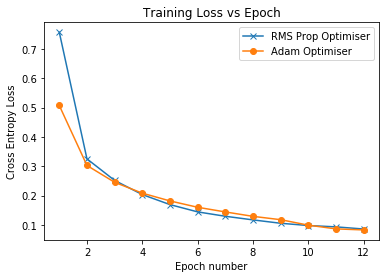

In [66]:
epoch_loss_t_r = np.mean(train_stats_l_r, axis = 1)
epoch_loss_v_r = np.mean(valid_stats_l_r, axis = 1)

length = min(len(epoch_loss_t_r), len(epoch_loss_t))
num_epochs = np.arange(1, length+1)

plt.plot(num_epochs, epoch_loss_t_r[:length], marker = 'x')
plt.plot(num_epochs, epoch_loss_t[:length], marker = 'o')
plt.xlabel('Epoch number')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss vs Epoch')
plt.legend(['RMS Prop Optimiser', 'Adam Optimiser'])
plt.show()

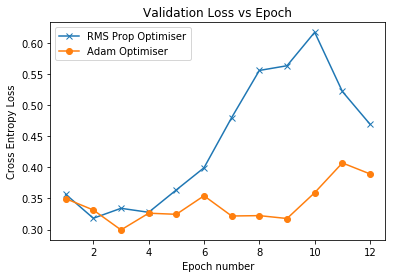

In [67]:
plt.plot(num_epochs, epoch_loss_v_r[:length], marker = 'x')
plt.plot(num_epochs, epoch_loss_v[:length], marker = 'o')
plt.xlabel('Epoch number')
plt.ylabel('Cross Entropy Loss')
plt.title('Validation Loss vs Epoch')
plt.legend(['RMS Prop Optimiser', 'Adam Optimiser'])
plt.show()

In [9]:
x_test, y_test = Loader.load_data(mode = 'test')
test_loader = Loader.create_batches(x_test, y_test, batch_size = batch_size)
num_samples_test = x_test.shape[0]

best_val_model = 'best_model_da.ckpt'

test()

Testing the model on 10000 Images!
INFO:tensorflow:Restoring parameters from ./model/best_model_da.ckpt
Testing Accuracy 0.897


In [46]:
tf.reset_default_graph()

import model

config = tf.ConfigProto(intra_op_parallelism_threads=6, inter_op_parallelism_threads=6,
                        device_count = {'CPU': 6})
x = tf.placeholder(dtype=tf.float32, shape = (None, x_train.shape[1]))
y = tf.placeholder(dtype=tf.float32, shape = (None, num_classes))

model = model.CNN(x, y)

saver = tf.train.Saver(tf.trainable_variables())

with tf.Session(config = config) as sess:
    sess.run(tf.local_variables_initializer())
    print('Testing the model on 10000 Images!')
    ckpt_file = os.path.join(model_dir, best_val_model)
    saver.restore(sess, ckpt_file)

    test_predicted = []
    for i, (batch_x, batch_y) in enumerate(test_loader):
        correct = sess.run(model.predictions['classes'], feed_dict = {x: batch_x, y: batch_y})
        test_predicted.append(correct)


Testing the model on 10000 Images!
INFO:tensorflow:Restoring parameters from ./model/best_model_da.ckpt


In [54]:
y_pred = test_predicted[0].reshape((-1,1))
for i in test_predicted[1:]:
    y_pred = np.vstack((y_pred, i.reshape((-1,1))))

In [58]:
y_pred = y_pred.reshape(-1)

classes = np.unique(y_test)

[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


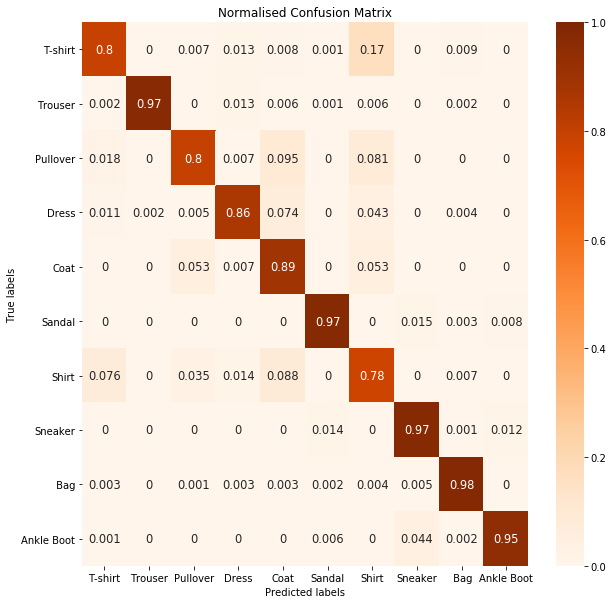

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_test, y_pred)
print(np.sum(cm, axis  = 1))
cm = cm/np.sum(cm, axis  = 1).reshape((1,-1))

names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', ' Bag', 'Ankle Boot']
cm = pd.DataFrame(cm, columns=names, index=names)

plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, vmin = 0, vmax = 1, cmap='Oranges', annot_kws={'size':11.5})
plt.yticks(rotation = 0)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Normalised Confusion Matrix')
plt.show()